In [1]:
#Clone our GitHub repository that contains the dataset of this exercise and also import the relevant packages:

!git clone https://github.com/sizhky/zero-shot-learning/
!pip install -Uq torch_snippets
%cd zero-shot-learning/src
import gzip
import _pickle as cPickle
from torch_snippets import *
from sklearn.preprocessing import LabelEncoder, normalize
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Cloning into 'zero-shot-learning'...
remote: Enumerating objects: 102, done.
remote: Total 102 (delta 0), reused 0 (delta 0), pack-reused 102
Receiving objects: 100% (102/102), 134.47 MiB | 33.33 MiB/s, done.
Resolving deltas: 100% (45/45), done.
     |████████████████████████████████| 209 kB 27.6 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 57 kB 3.7 MB/s 
     |████████████████████████████████| 51 kB 5.1 MB/s 
/content/zero-shot-learning/src


2021-08-08 19:04:00.597 | WARNING  | torch_snippets.torch_loader:<module>:233 - Error: No module named 'pytorch_lightning'
Not importing Lightning Report
2021-08-08 19:04:01.451 | WARNING  | torch_snippets:<module>:14 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [2]:
# define the paths to features data
WORD2VECPATH =  "../data/class_vectors.npy"
DATAPATH = "../data/zeroshot_data.pkl"

In [3]:
# Extract the list of classes available

with open('train_classes.txt','r') as infile:
    train_classes = [str.strip(line) for line in infile]

In [4]:
#

In [6]:
#load the feature vector data

with gzip.GzipFile(DATAPATH,'rb') as infile:
    data = cPickle.load(infile)

In [7]:
training_data = [instance for instance in data if instance[0] in train_classes]
zero_shot_data = [instance for instance in data if instance[0] not in train_classes]
np.random.shuffle(training_data)

In [8]:
train_size = 300 #per class
train_data,valid_data = [],[]
for class_label in train_classes:
    ctr = 0
    for instance in training_data:
        if instance[0] == class_label:
            if ctr < train_size:
                train_data.append(instance)
                ctr+=1
            else:
                valid_data.append(instance)

In [9]:
np.random.shuffle(train_data)
np.random.shuffle(valid_data)
vectors = {i:j for i,j in np.load(WORD2VECPATH, allow_pickle=True)}

In [11]:
# fetch the image and word embedding features for training and validation data

train_data = [(feat,vectors[clss]) for clss,feat in train_data]
valid_data = [(feat,vectors[clss]) for clss,feat in valid_data]

In [12]:
# fetch the training,validation,and zero_shot_classes:
train_clss = [clss for clss,feat in train_data]
valid_clss = [clss for clss,feat in valid_data]
zero_shot_clss = [clss for clss,feat in zero_shot_data]

In [13]:
x_train, y_train = zip(*train_data)
x_train, y_train = np.squeeze(np.asarray(x_train)), np.squeeze(np.asarray(y_train))
x_train = normalize(x_train, norm='l2')

x_valid, y_valid = zip(*valid_data)
x_valid, y_valid = np.squeeze(np.asarray(x_valid)), np.squeeze(np.asarray(y_valid))
x_valid = normalize(x_valid, norm='l2')

y_zsl, x_zsl = zip(*zero_shot_data)
x_zsl, y_zsl = np.squeeze(np.asarray(x_zsl)), np.squeeze(np.asarray(y_zsl))
x_zsl = normalize(x_zsl, norm='l2')

In [14]:
# Define the training and validation datasets and dataLoaders..


from torch.utils.data import TensorDataset

trn_ds = TensorDataset(*[torch.Tensor(t).to(device) for t in [x_train, y_train]])
val_ds = TensorDataset(*[torch.Tensor(t).to(device) for t in [x_valid, y_valid]])

trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

In [15]:
def build_model():
    return nn.Sequential(
        nn.Linear(4096, 1024), nn.ReLU(inplace=True),
        nn.BatchNorm1d(1024), nn.Dropout(0.8),
        nn.Linear(1024, 512), nn.ReLU(inplace=True),
        nn.BatchNorm1d(512), nn.Dropout(0.8),
        nn.Linear(512, 256), nn.ReLU(inplace=True),
        nn.BatchNorm1d(256), nn.Dropout(0.8),
        nn.Linear(256, 300)
    )

In [16]:
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss = criterion(_preds, labels)
    return loss.item()

EPOCH: 10.000	trn_loss: 0.020	val_loss: 0.020	(142.79s - 713.97s remaining)
EPOCH: 20.000	trn_loss: 0.014	val_loss: 0.014	(283.62s - 567.23s remaining)
EPOCH: 30.000	trn_loss: 0.013	val_loss: 0.014	(421.24s - 421.24s remaining)
EPOCH: 40.000	trn_loss: 0.012	val_loss: 0.013	(559.33s - 279.66s remaining)
EPOCH: 50.000	trn_loss: 0.011	val_loss: 0.013	(692.00s - 138.40s remaining)
EPOCH: 60.000	trn_loss: 0.011	val_loss: 0.013	(819.58s - 0.00s remaining)


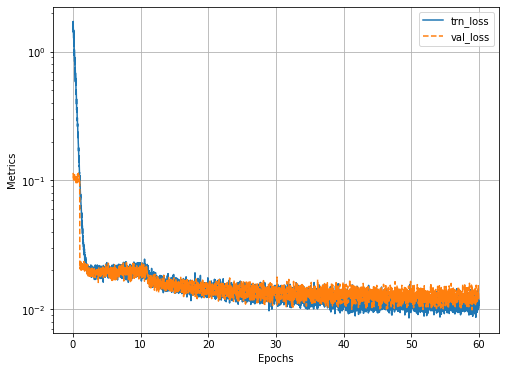

In [17]:
model = build_model().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 60

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, end='\r')
        
    if ex == 10: optimizer = optim.Adam(model.parameters(), lr=1e-4)
    if ex == 40: optimizer = optim.Adam(model.parameters(), lr=1e-5)
    if not (ex+1)%10: log.report_avgs(ex+1)

log.plot(log=True)

In [18]:
pred_zsl = model(torch.Tensor(x_zsl).to(device)).cpu().detach().numpy()

class_vectors = sorted(np.load(WORD2VECPATH, allow_pickle=True), key=lambda x: x[0])
classnames, vectors = zip(*class_vectors)
classnames = list(classnames)

vectors = np.array(vectors)

In [19]:
dists = (pred_zsl[None] - vectors[:,None])
dists = (dists**2).sum(-1).T

best_classes = []
for item in dists:
    best_classes.append([classnames[j] for j in np.argsort(item)[:5]])

np.mean([i in J for i,J in zip(zero_shot_clss, best_classes)])

0.735367683841921